In [1]:
import os
from shutil import copyfile, rmtree

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow


import warnings; warnings.simplefilter('ignore')

import PIL
from PIL import ImageDraw

from tqdm import tqdm_notebook

%matplotlib inline

In [30]:
os.listdir("./minimap/images")

['raw_nomap', 'map', 'nomap']

In [31]:
data_dir = "./minimap/images"
data = None

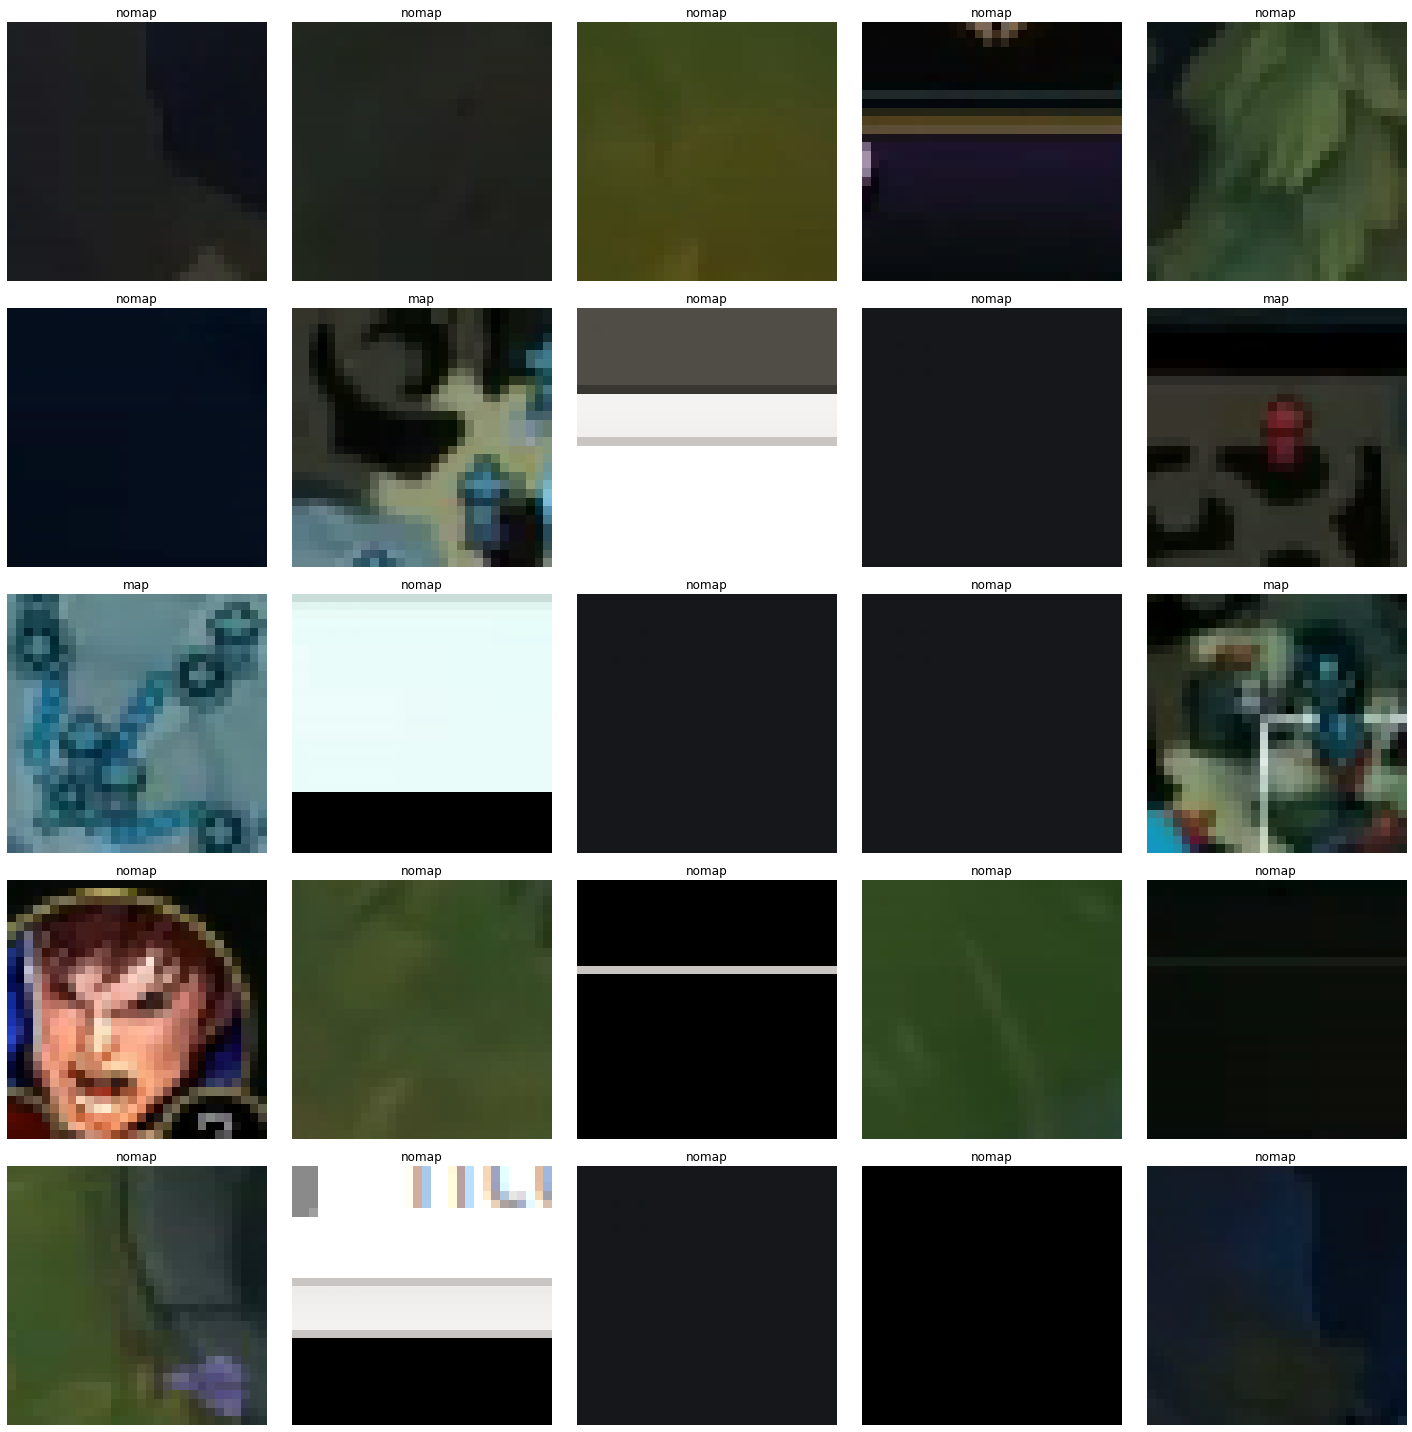

In [32]:
tfms = [[rand_zoom(p=1.0)], []]
data = ImageDataBunch.from_folder(data_dir, classes=["map", "nomap"], bs=256, ds_tfms=tfms)
data.show_batch()

In [34]:
def get_score(learn):
    preds = learn.get_preds(DatasetType.Valid)[0]
    score = 0
    for i in range(len(learn.data.valid_dl.y)):
        if preds[i][0] > preds[i][1] and learn.data.valid_dl.y[i].data == 0:
            score+=1
        elif preds[i][0] < preds[i][1] and learn.data.valid_dl.y[i].data == 1:
            score+=1    

    return score

In [36]:
best_learn = None
best_score = 0
lr = 0.02

for i in range(0, 1):
    learn = create_cnn(data, models.resnet18, metrics=[accuracy])
    gc.collect()
    learn.callbacks = [SaveModelCallback(learn, every='improvement', mode='min', name='best')]
    learn.fit_one_cycle(1, lr)
    learn.unfreeze()
    learn.fit_one_cycle(3, slice(1e-6, lr/5))

    new_score = get_score(learn)
    if new_score > best_score or not best_learn:
        best_learn = learn
        best_score = new_score
    print(f'Run {i} - Best Score: {best_score}')

epoch,train_loss,valid_loss,accuracy,time
0,0.014799,0.007806,0.997955,00:11


Better model found at epoch 0 with valid_loss value: 0.007806343492120504.


epoch,train_loss,valid_loss,accuracy,time
0,0.010768,0.005640,0.998364,00:14
1,0.004875,0.005896,0.998773,00:14
2,0.003032,0.005933,0.998927,00:14


Better model found at epoch 0 with valid_loss value: 0.005640115588903427.


Run 0 - Best Score: 19531


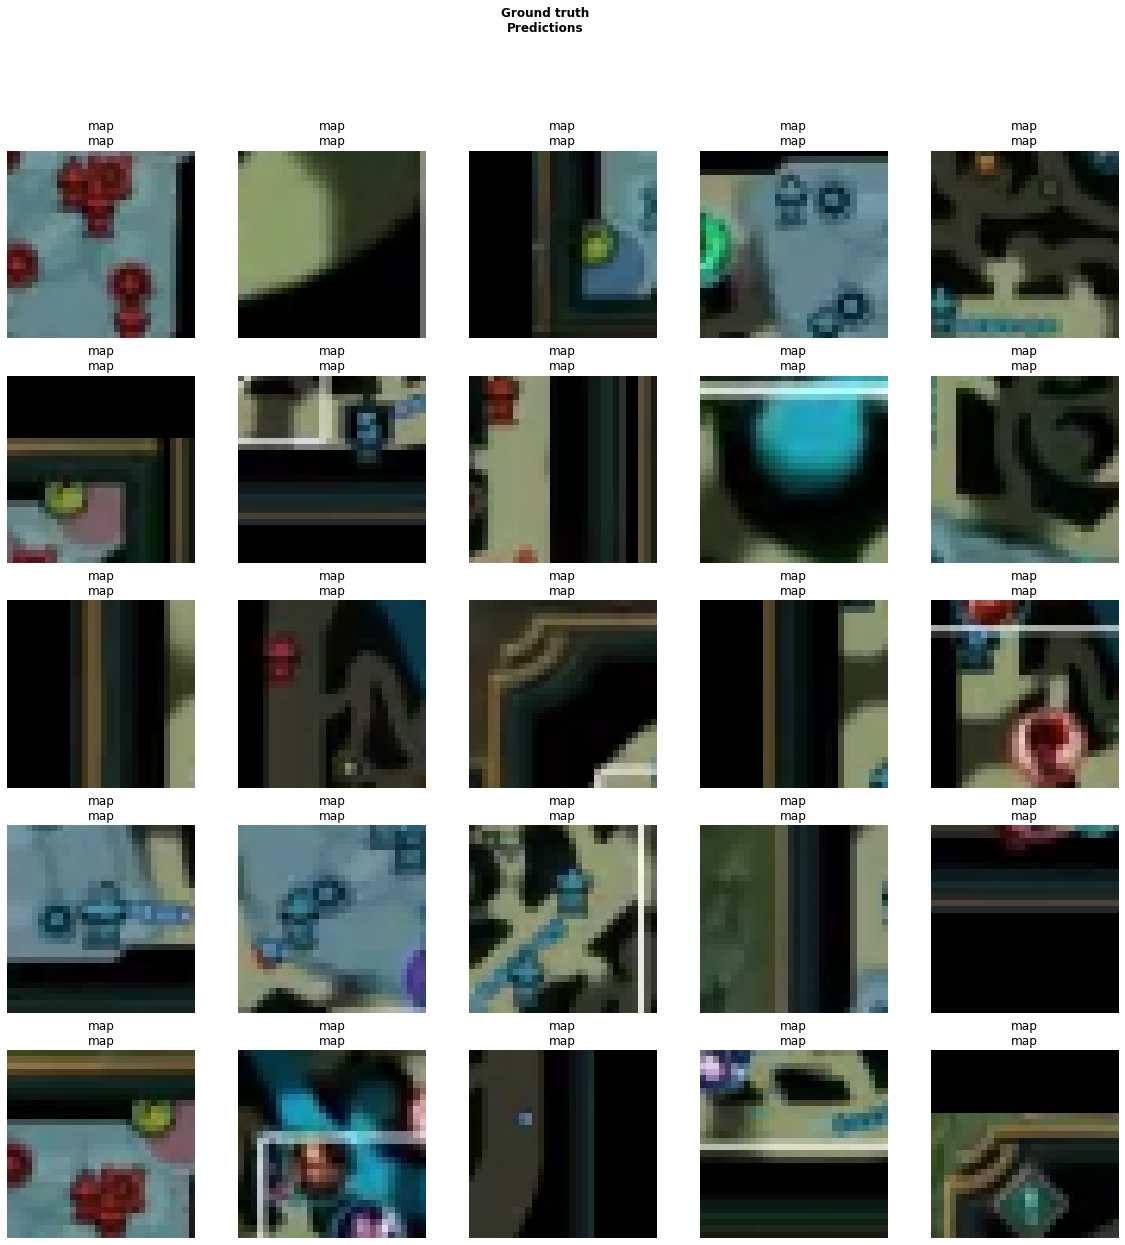

In [38]:
best_learn.show_results()

In [39]:
model_path = 'models/'
learn.export(model_path+"minimap.pth")